<a href="https://colab.research.google.com/github/anjali88/Data-Science/blob/master/Retail_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

from datetime import datetime
import datetime


# Load Dataset

In [82]:
from google.colab import files
uploaded = files.upload()

Saving beacon_data.csv to beacon_data.csv


# Pre-Process Data

In [0]:
## ------------------------------------------------------------------------------------------  
## GET OUTLIERS 
## this function can be used on any dataset to return a list of index values for the outliers 
def get_outliers(data, columns):
    # we create an empty list
    outlier_idxs = []
    for col in columns:
        elements = data[col]
        # we get the mean value for each column
        mean = elements.mean()
        # and the standard deviation of the column
        sd = elements.std()
        # we then get the index values of all values higher or lower than the mean +/- 3 standard deviations
        outliers_mask = data[(data[col] > mean + 3*sd) | (data[col]  < mean  - 3*sd)].index
        # and add those values to our list
        outlier_idxs  += [x for x in outliers_mask]
    return list(set(outlier_idxs))
#-------------------------------------------------------------------------------------------    
# DROP OUTLIERS
def drop_outliers(df):
  print(df.shape)
  numeric_columns = ['distance','rssi','duration']
  outliers = get_outliers(df, numeric_columns)
  #print('Outliers: ',df.loc[outliers,:])
  df.drop(outliers, axis = 0, inplace=True) 
  #print(df.shape) 
#
#-----------------------------------------------------------------------------------------
## AGGREGATE VISITS BY DATE 
##Function that will aggregate dataset by date
def aggregate_sales_by_date(df):
  # sort original dataset
  df.sort_values(by=['vendor_id','subscriber_id','date','entry_time'], inplace=True)
  #
  # Create dataset that will hold data aggregated by date
  # start and end date to use as index
  start = df['date'].min()
  end = df['date'].max()
  # pandas has handy date_range() function. It's very flexible and powerful.
  # create range of dates to use as index
  rng = pd.date_range(start, end) 
  # create dataframe that will hold aggregated data with index as range of dates
  visits_by_date = pd.DataFrame(index=rng)
  #
  # start adding features to the dataset
  # add weekday feature
  visits_by_date['weekday'] = visits_by_date.index.map(lambda x: x.weekday())
  print(visits_by_date)
  #
  # group original dataframe by date
  grp_date = df.groupby(['date'])
  #
  # #calculate number of sales and time spent per day. Assume sale corresponds to proximity_immediate
  visit_duration_by_date = pd.DataFrame(grp_date.sum(), columns=['proximity_immediate', 'duration'])
  # merge into the 
  visits_by_date = pd.merge(visits_by_date, visit_duration_by_date, how='left', 
      left_index=True, right_index=True, sort=True)
  #
  ##calculate unique visits per day
  unique_visits_by_date = pd.DataFrame(grp_date.nunique(), columns=['subscriber_id'])
  # Merge the two dataframe doing a left join 
  visits_by_date = pd.merge(visits_by_date, unique_visits_by_date, how='left', 
      left_index=True, right_index=True, sort=True)
  #
  # rename columns that hold aggregated data
  visits_by_date.rename(columns={"subscriber_id": "num_visitors", "proximity_immediate": "num_sales"}, inplace=True)
  
  visits_by_date['average_duration'] = visits_by_date['duration'] / visits_by_date['num_visitors']
  # distance and rssi
  average_distance_rssi =  pd.DataFrame(grp_date.mean(), columns=['distance', 'rssi'])
  # merge 
  visits_by_date = pd.merge(visits_by_date, average_distance_rssi, how='left', 
      left_index=True, right_index=True, sort=True)
  
  visits_by_date['distance'].fillna(1000, inplace=True)
  visits_by_date['rssi'].fillna(-100, inplace=True)
  visits_by_date['average_duration'].fillna(0, inplace=True)
  visits_by_date['duration'].fillna(0, inplace=True)
  visits_by_date['num_sales'].fillna(0, inplace=True)
  visits_by_date['num_visitors'].fillna(0, inplace=True)

  #
  #print(visits_by_date)
  return visits_by_date  
  #
  #--------------------------------------------------------------------------------

In [0]:
## PREPROCESS DATA
def preprocess_data(inputFile,outputFile):
#basic preprocessing for converting raw inputfile to preprocessed file
#read csv file that uses ';' as separator
  #dataset = pd.read_csv(io.StringIO(uploaded[inputFile].decode('utf-8')), sep=';')
  dataset = pd.read_csv(inputFile, sep=';')
  #
  # drop columns that don's contain useful data
  dataset.drop('id', axis=1, inplace=True)
  dataset.drop('gtid', axis=1, inplace=True)
  dataset.drop('dongle_id', axis=1, inplace=True)
  dataset.drop('merchant_id', axis=1, inplace=True)
  dataset.drop('latitude', axis=1, inplace=True)
  dataset.drop('longitude', axis=1, inplace=True)
  dataset.drop('exit_date', axis=1, inplace=True)
  #
  # remove duplicate rows
  column_names = ['vendor_id','subscriber_id','signal_type','entry_date','distance','proximity','rssi']
  dataset.drop_duplicates(subset=column_names,keep='first',inplace=True)
  #
  # get list of vendors who have at least one recorded sale , i.e. proximity == immediate or subscriber in near proximity 
  # vendors without recorded sales or near proximity will be dropped 
  #agg = dataset.loc[(dataset['proximity'] == 'immediate') | (dataset['proximity'] == 'near')].groupby(['vendor_id']).agg(['count'])
  agg = dataset.loc[(dataset['proximity'] == 'near')].groupby(['vendor_id']).agg(['count'])
  vendors_to_keep = agg.loc[agg['subscriber_id','count'] >= 1].index.tolist()
  
  # remove rows with nonsense data, like negative distance
  # drop rows for vendors that dont have at least one recorded sale , proximity == immediate
  # drop rows with proximity far as this is just noise
  indexNames = dataset[ (dataset['distance'] < 0)  | ~dataset['vendor_id'].isin(vendors_to_keep) | (dataset['proximity'] == 'far')].index
  # Delete these row indexes from dataFrame
  dataset.drop(indexNames , inplace=True)
  #
  # add extra features to the dataset
  # convert proximity column to categorical data columns
  # this will help aggregation
  dummies = pd.get_dummies(dataset['proximity'], prefix='proximity')
  dataset = dataset.join(dummies)
  # now drop proximity column
  dataset.drop('proximity', axis=1, inplace=True)
  #
  # extract date and time from entry_date
  dataset['date'] = dataset['entry_date'].apply(lambda x: pd.to_datetime(x).date())
  dataset['entry_time'] = dataset['entry_date'].apply(lambda x: pd.to_datetime(x).time())
  #
  # convert signal_type to 0 (entry) and 1 (exit)
  dataset['signal_type'] = dataset['signal_type'].apply(lambda x: x/2 -1)
  #
  # sort dataset 
  dataset.sort_values(by=['vendor_id','subscriber_id','date','entry_time'], inplace = True)
  # add previous_vendor, previous_signal_type, previous_subscriber_id, previous_date columns
  # this will allow calculating visit duration
  dataset['previous_vendor_id'] = dataset['vendor_id'].shift(1).fillna(0)
  dataset['previous_date'] = dataset['date'].shift(1).fillna(dataset['date'])
  dataset['previous_signal_type'] = dataset['signal_type'].shift(1).fillna(dataset['signal_type'])
  dataset['previous_subscriber_id'] = dataset['subscriber_id'].shift(1).fillna(0)
  
  # add duration column to dataset
  dataset['duration'] = (pd.to_datetime(dataset['entry_date']) - pd.to_datetime(dataset['entry_date'])
                 .shift(1).fillna(pd.to_datetime(dataset['entry_date']))).apply(lambda x: pd.Timedelta.total_seconds(x))
  # set duration to 0 if previous signal type is 1 as exit starts a new visit
  dataset.loc[(dataset['previous_signal_type'] == 1),'duration'] = 0
  dataset.loc[(dataset['previous_subscriber_id'] != dataset['subscriber_id']),'duration'] = 0
  dataset.loc[(dataset['previous_date'] != dataset['date']),'duration'] = 0
  dataset.loc[(dataset['previous_vendor_id'] != dataset['vendor_id']),'duration'] = 0
  #
  # drop rows with signal type = 1 (exit) 
  indexNames = dataset[ (dataset['signal_type'] == 1) ].index
  # Delete these row indexes from dataFrame
  dataset.drop(indexNames , inplace=True)
  #
  #
  #  now drop some  columns
  dataset.drop('previous_vendor_id', axis=1, inplace=True)
  dataset.drop('signal_type', axis=1, inplace=True)
  dataset.drop('previous_subscriber_id', axis=1, inplace=True)
  dataset.drop('previous_date', axis=1, inplace=True)
  dataset.drop('previous_signal_type', axis=1, inplace=True)
  #
  # drop outliers
  #ds_far = dataset[dataset['proximity_far']==1]
  ds_near = dataset[dataset['proximity_near']==1]
  ds_immediate = dataset[dataset['proximity_immediate']==1]
  ds_exit = dataset[(dataset['proximity_immediate']==0) & (dataset['proximity_near']==0)]
  #drop outliers
  #drop_outliers(ds_far)
  drop_outliers(ds_near)
  #drop_outliers(ds_immediate)
  drop_outliers(ds_exit)
  dataset_no_outliers = pd.concat([ds_near,ds_immediate,ds_exit])
  #drop proximity_far , proximity_near columns
  #dataset_no_outliers.drop('proximity_far', axis=1, inplace=True)
  dataset_no_outliers.drop('proximity_near', axis=1, inplace=True)
  dataset_no_outliers.sort_values(by=['vendor_id','subscriber_id','date','entry_time'], inplace = True)
  #print(dataset_no_outliers.head(5))
  dataset_no_outliers = dataset_no_outliers.fillna(0)
  # save to file
  dataset_no_outliers.to_csv(outputFile)


In [87]:
# Preprocess the data
preprocess_data('beacon_data.csv','beacon_data_preprocessed.csv')

(2554, 10)
(0, 10)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [88]:
#read preprocessed csv file
df=pd.read_csv('beacon_data_preprocessed.csv',header=0, index_col=0)
print(df.columns)

Index(['vendor_id', 'subscriber_id', 'entry_date', 'distance', 'rssi',
       'proximity_immediate', 'date', 'entry_time', 'duration'],
      dtype='object')


In [89]:
# check missing values
df.isnull().sum()

vendor_id              0
subscriber_id          0
entry_date             0
distance               0
rssi                   0
proximity_immediate    0
date                   0
entry_time             0
duration               0
dtype: int64

In [90]:
df.dtypes

vendor_id                int64
subscriber_id            int64
entry_date              object
distance               float64
rssi                   float64
proximity_immediate      int64
date                    object
entry_time              object
duration               float64
dtype: object

In [91]:
df['vendor_id'].unique()

array([  6,  46,  47,  88, 110, 112, 114, 118, 133, 135, 137, 138, 140,
       141, 144, 146, 157, 167, 168, 178, 275, 331, 342, 344, 347, 349,
       353, 388, 407, 428, 430, 433])

In [92]:
# aggregate dataset
sales_by_date = aggregate_sales_by_date(df)
sales_by_date

            weekday
2017-05-01        0
2017-05-02        1
2017-05-03        2
2017-05-04        3
2017-05-05        4
...             ...
2017-09-15        4
2017-09-16        5
2017-09-17        6
2017-09-18        0
2017-09-19        1

[142 rows x 1 columns]


,weekday,num_sales,duration,num_visitors,average_duration,distance,rssi
2017-05-01,0,0,454.0,10,45.400000,266.890201,-77.000000
2017-05-02,1,0,2633.0,12,219.416667,283.981697,-74.129032
2017-05-03,2,0,1808.0,17,106.352941,263.444114,-72.137931
2017-05-04,3,0,90.0,8,11.250000,230.109310,-71.400000
2017-05-05,4,0,933.0,11,84.818182,242.321759,-75.352941
...,...,...,...,...,...,...,...
2017-09-15,4,0,1422.0,9,158.000000,258.005432,-77.764706
2017-09-16,5,0,287.0,10,28.700000,264.661302,-71.666667
2017-09-17,6,0,283.0,8,35.375000,285.343102,-70.666667
2017-09-18,0,0,1838.0,10,183.800000,254.689858,-73.625000


# Correlation and Relevant Features

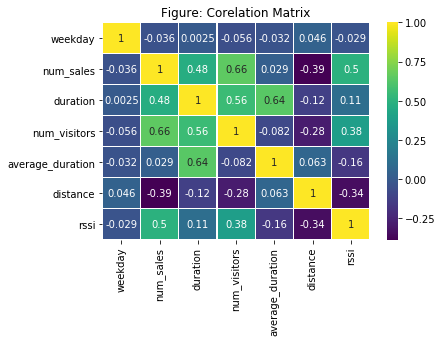

In [93]:
import seaborn as sns
cor=sales_by_date.corr(method='pearson')
plt.title("Figure: Corelation Matrix")
cm=plt.cm.viridis
corr = sns.heatmap(cor,cmap=cm,linewidths=0.1,linecolor='white',annot=True)
plt.show()

In [94]:
# We will only select features which has correlation of above 0.50 (taking absolute value) with the num_sales. 
# Correlation with target
cor_target = abs(cor["num_sales"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.50]
print("Relevant Features:\n")
print(relevant_features)

Relevant Features:

num_sales       1.000000
num_visitors    0.658339
rssi            0.501261
Name: num_sales, dtype: float64


In [96]:
# We will only select features which has correlation of above 0.50 (taking absolute value) with the num_sales. 
# Correlation with target
cor_target = abs(cor["num_sales"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.50]
print("Relevant Features:\n")
print(relevant_features)

Relevant Features:

num_sales       1.000000
num_visitors    0.658339
rssi            0.501261
Name: num_sales, dtype: float64


# Seasonal Decompose - Trend Analysis

<Figure size 1152x576 with 0 Axes>

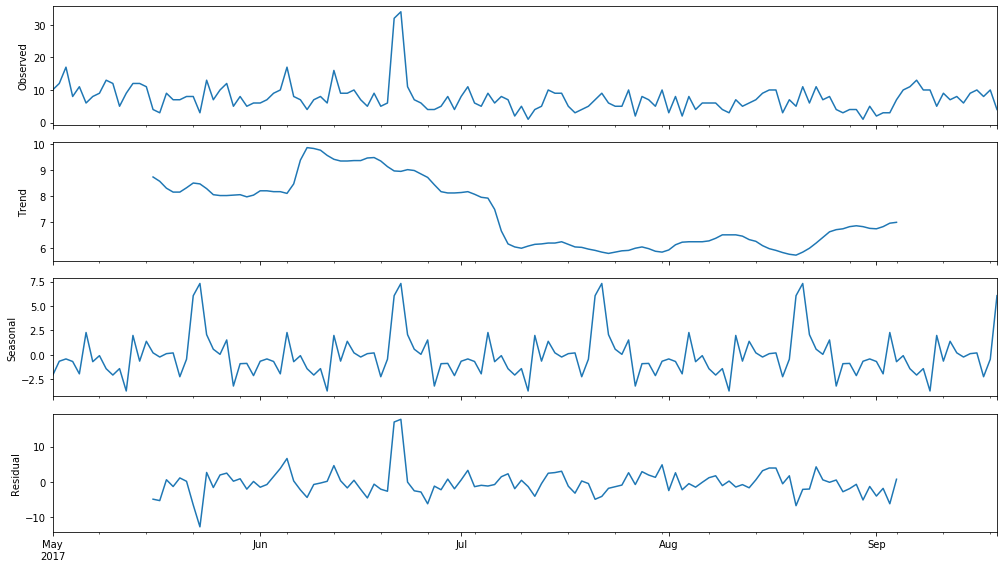

             t       t+1       t+5      t+10      t+30
t     1.000000 -0.066640  0.166603 -0.023644  0.411067
t+1  -0.066640  1.000000 -0.081274  0.042735 -0.078390
t+5   0.166603 -0.081274  1.000000 -0.123279  0.148625
t+10 -0.023644  0.042735 -0.123279  1.000000  0.011779
t+30  0.411067 -0.078390  0.148625  0.011779  1.000000


In [97]:
rcParams['figure.figsize'] = 14, 8
data_season = sales_by_date['num_visitors']
result = seasonal_decompose(data_season, model='additive', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

values = DataFrame(sales_by_date['num_visitors'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

# Train & Test

MSE: 8.912115651656416
MAE: 2.529929577464789
RMSE: 2.985316675271891


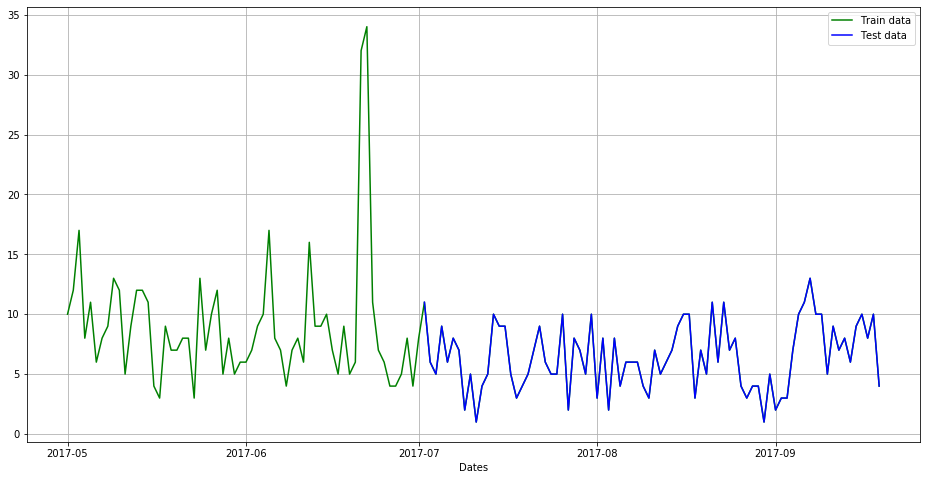

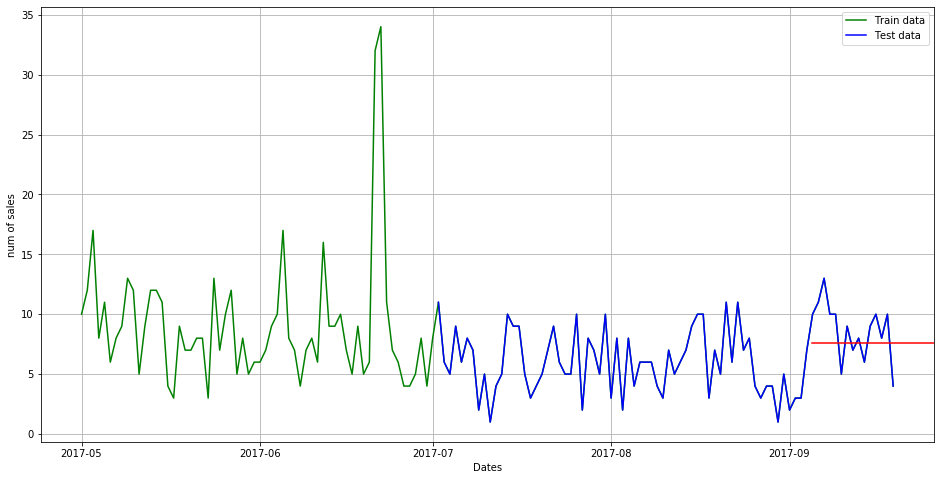

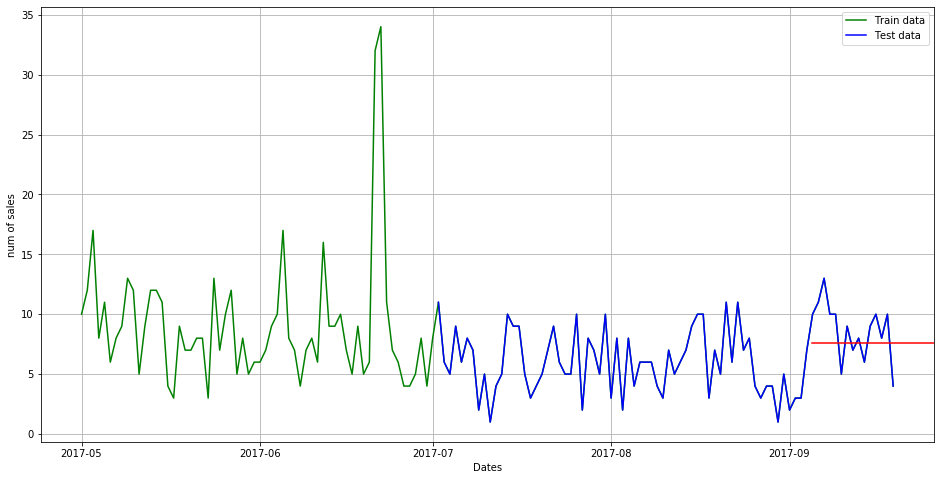

In [99]:
train_data, test_data = sales_by_date[0:80], sales_by_date[-80:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('')
plt.plot(sales_by_date['num_visitors'], 'green', label='Train data')
plt.plot(test_data['num_visitors'], 'blue', label='Test data')
plt.legend()

# Mean value plot
mean_value = sales_by_date['num_visitors'].mean() # calculation of mean 

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('num of sales')
plt.plot(sales_by_date['num_visitors'], 'green', label='Train data')
plt.plot(test_data['num_visitors'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('num of sales')
plt.plot(sales_by_date['num_visitors'], 'green', label='Train data')
plt.plot(test_data['num_visitors'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['num_visitors'], np.full(len(test_data), mean_value))))
print('MAE: '+str(mean_absolute_error(test_data['num_visitors'], np.full(len(test_data), mean_value))))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['num_visitors'], np.full(len(test_data), mean_value)))))

#ARIMA

In [112]:
!pip install utils

In [114]:
! pip install mxnet

     |████████████████████████████████| 25.4MB 43.2MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [117]:
from pandas import DataFrame
from pandas import datetime
from utils import *

import time
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx


import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

series = sales_by_date['num_visitors']
model = ARIMA(series, order=(1, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.num_visitors   No. Observations:                  141
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -412.867
Method:                       css-mle   S.D. of innovations              4.522
Date:                Sat, 01 Feb 2020   AIC                            831.735
Time:                        17:23:27   BIC                            840.581
Sample:                    05-02-2017   HQIC                           835.330
                         - 09-19-2017                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0366      0.300     -0.122      0.903      -0.624       0.551
ar.L1.D.num_visitors    -0.2720      0.081     -3.349      0.001      -0.431      -0.113
            

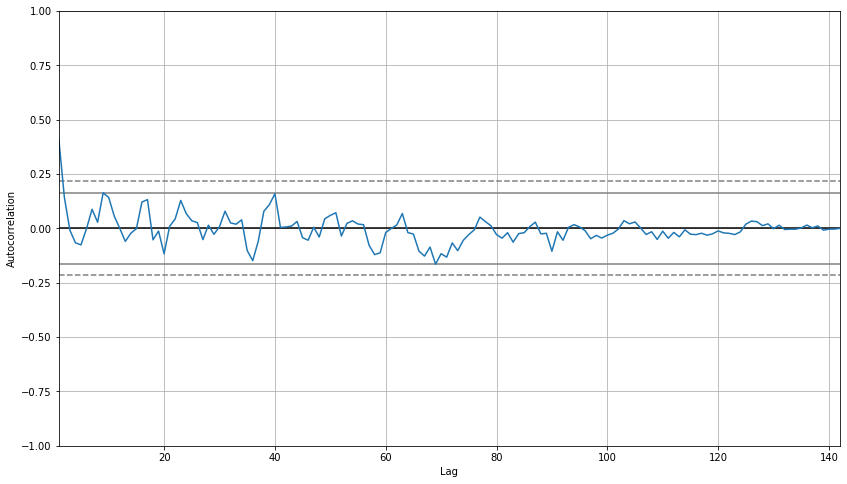

<Figure size 800x560 with 0 Axes>

In [118]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

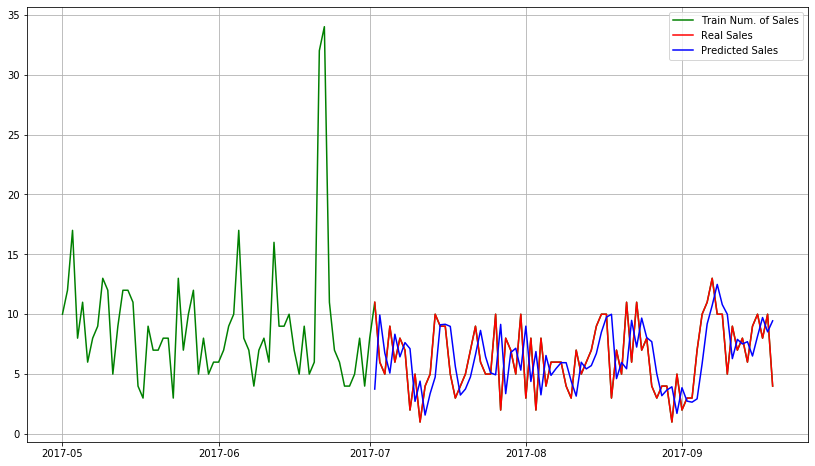

MSE: 9.605479349608832
MAE: 2.516781925408195
RMSE: 3.0992707770714114


In [121]:
# ARIMA model
train_arima = train_data['num_visitors']
test_arima = test_data['num_visitors']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1, 1, 0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
  # predict
    model = ARIMA(history, order=(1, 1, 0))
    model_fit = model.fit(disp=0)
    #print(model_fit.summary())
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    
plt.figure(figsize=(14,8))
plt.plot(sales_by_date.index[-142:], sales_by_date['num_visitors'], color='green', label = 'Train Num. of Sales')
plt.plot(test_data.index, y, color = 'red', label = 'Real Sales')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Sales')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

# LSTM

In [0]:
train = train_data.iloc[:, 0:1].values # selecting num_sales
# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 
# Train dataset
timesteps = 1
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) 
    y_train.append(train_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

In [101]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
LSTM_ml = model.fit(X_train, y_train, epochs = 20, batch_size = 16)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





79/79 [==============================] - 2s 22ms/step - loss: 0.3460
Epoch 2/20
79/79 [==============================] - 0s 447us/step - loss: 0.3230
Epoch 3/20
79/79 [==============================] - 0s 470us/step - loss: 0.2988
Epoch 4/20
79/79 [==============================] - 0s 468us/step - loss: 0.2715
Epoch 5/20
79/79 [==============================] - 0s 443us/step - loss: 0.2455
Epoch 6/20
79/79 [==============================] - 0s 391us/step - loss: 0.2225
Epoch 7/20
79/79 [==============================] - 0s 433us/step - loss: 0.1924
Epoch 8/20
79/79 [==============================] - 0s 431us/step - loss: 0.1622
Epoch 9/20
79/79 [==============================] - 0s 511us/step - loss: 0.1407
Epoch 10/20
79/79 [==============================]

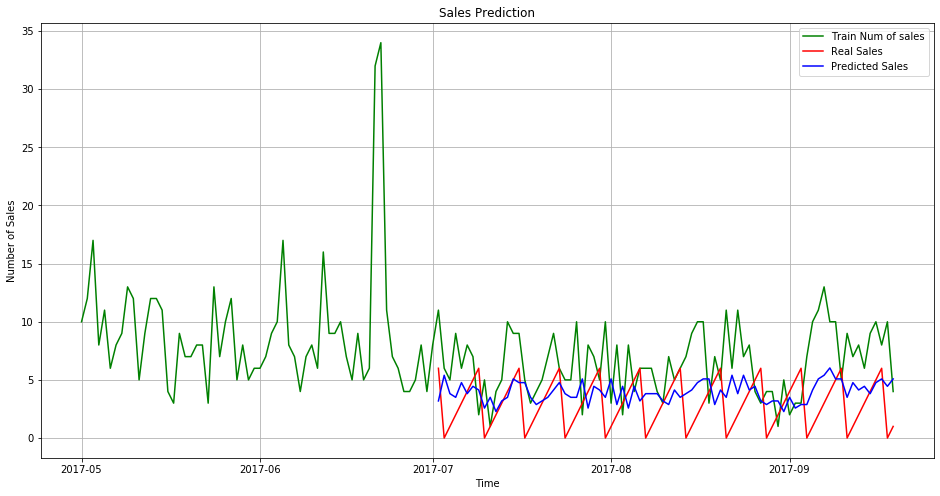

MSE: 5.558949151874732
MAE: 1.9688269406557084
RMSE: 2.357742384543895


In [110]:
# this will be used later while comparing and visualization
real_num_sales = test_data.iloc[:,0:1].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['num_visitors'], test_data['num_visitors']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_num_sales = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_num_sales = scaler.inverse_transform(predicted_num_sales)

plt.figure(figsize=(16,8))
plt.plot(sales_by_date.index[-142:], sales_by_date['num_visitors'], color='green', label = 'Train Num of sales')
plt.plot(test_data.index, real_num_sales, color = 'red', label = 'Real Sales')
plt.plot(test_data.index, predicted_num_sales, color = 'blue', label = 'Predicted Sales')
plt.title('Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Sales')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_num_sales, predicted_num_sales)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_num_sales, predicted_num_sales)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_num_sales, predicted_num_sales))
print('RMSE: '+str(rmse))